# CIMR Level-2 Terrestrial Snow Area

In [1]:
import os 
import sys
import numpy as np
import xarray as xr
import pyresample as pr
import importlib
from matplotlib import pyplot as plt
from matplotlib import colors

# local imports
if '/tools/' not in sys.path:
    sys.path.insert(0, os.path.abspath('../.../') + 'algorithm/tools/')
import l2_format as l2
import TSA_algorithm as algorithm
import l2_tools as tools

In [2]:
# reload local imports
importlib.reload(l2)
importlib.reload(algorithm)
importlib.reload(tools)

<module 'l2_tools' from 'C:\\Users\\zschende\\OneDrive - Ilmatieteen laitos\\Files\\Projects\\CIMR Devalgo\\ATBD\\TerrestrialSnowArea_ATBD_v2\\algorithm/tools\\l2_tools.py'>

In [3]:
test_card_name = 'devalgo_radiometric'
# test_card_name = 'devalgo_geometric'

if test_card_name == 'devalgo_radiometric':
    l1x = 'C:/Users/zschende/OneDrive - Ilmatieteen laitos/Files/Projects/CIMR Devalgo/Data/L1C Files/Radiometric/W_PT-DME-Lisbon-SAT-CIMR-1X@KA_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc'
elif test_card_name == 'devalgo_geometric':
    l1x = 'C:/Users/zschende/OneDrive - Ilmatieteen laitos/Files/Projects/CIMR Devalgo/Data/L1C Files/Geometric/W_PT-DME-Lisbon-SAT-CIMR-1X@KA_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc'

l1b_path = l1x      # os.path.basename(l1b_path) for netcdf
data_fwd,geo_fwd,data_bck,geo_bck = tools.read_l1x(l1x)

l2_dir = 'C:/Users/zschende/OneDrive - Ilmatieteen laitos/Files/Projects/CIMR Devalgo/Data/L2 Files/'
l2_grid = 'ease2_nh_3.125km'
algo = 'Pulliainen2010'
algo_version = '0.9.0'

## Step 1: Dry Snow Detection

In [4]:
# detection forward and backward
TSA_fwd = algorithm.dry_snow_detection(data_fwd,tsa_algorithm=algo)
TSA_bck = algorithm.dry_snow_detection(data_bck,tsa_algorithm=algo)

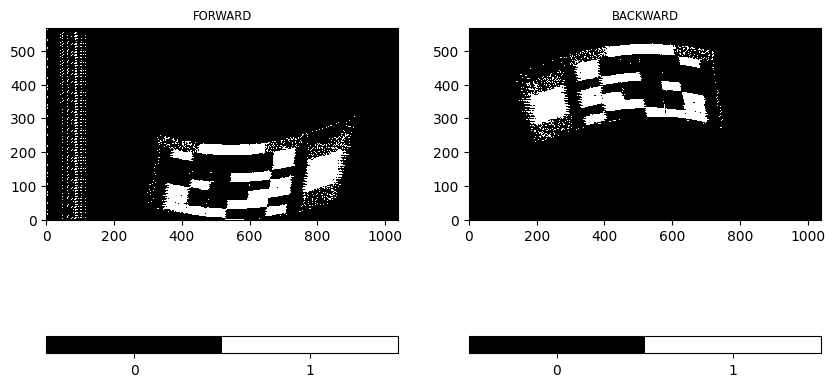

In [5]:
cmap = colors.ListedColormap(['black', 'white'])
vrange=[0,.5,1]
# cmap.set_bad(color='red')

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10,10))

img = ax[0].imshow(TSA_fwd, vmin=0, vmax=1, interpolation='none', origin='lower', cmap=cmap)
ax[0].set_title('FORWARD', fontsize='small')
# plt.text(0.01,0.99,'TSA',va='top',color='white')
cbar = plt.colorbar(img, boundaries=vrange, ticks=[0.25, 0.75], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '1'])

img = ax[1].imshow(TSA_bck, vmin=0, vmax=1, interpolation='none', origin='lower', cmap=cmap)
ax[1].set_title('BACKWARD', fontsize='small')
# plt.text(0.01,0.99,'TSA',va='top',color='white')
cbar = plt.colorbar(img, boundaries=vrange, ticks=[0.25, 0.75], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '1'])
    
# fig.savefig('tsa_swath.png', format='png', dpi=1200, bbox_inches='tight')
plt.show()

## Step 2: Combined Reprojection

Reprojection for nominal TSA product: EASE2 3.125km

Note that for the Algorithm Performance Assessment, the target grid is the same as the Test Card, namely EASE2 1km.

In [6]:
area_def = pr.load_area('ease2_adef.yaml',l2_grid)

### Step 2.1: Individual Reprojection

In [7]:
TSA_fwd_proj = tools.reproject_to_grid(TSA_fwd,geo_fwd,area_def=area_def)
TSA_bck_proj = tools.reproject_to_grid(TSA_bck,geo_bck,area_def=area_def)

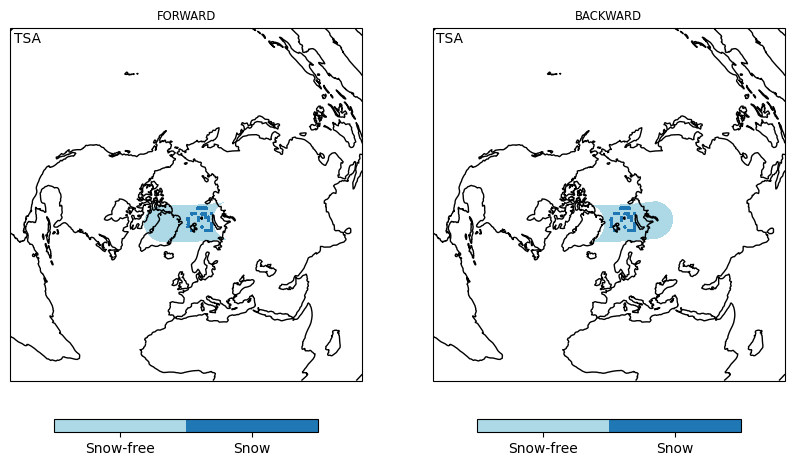

In [8]:
cmap = colors.ListedColormap(['lightblue', 'tab:blue'])
# cmap.set_bad(color='lightgrey')

vrange = [-0.5,0.5,1.5]
norm = colors.BoundaryNorm(vrange, cmap.N)

cart_crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,10),
                       subplot_kw=dict(projection=cart_crs))

img = ax[0].imshow(TSA_fwd_proj, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap)
ax[0].coastlines(color='black')
ax[0].set_title('FORWARD', fontsize='small')
ax[0].text(0.01,0.99,'TSA',va='top',transform=ax[0].transAxes)
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[0,1], orientation='horizontal', pad=0.05, shrink=0.75)
cbar.ax.set_xticklabels(['Snow-free', 'Snow'])

img = ax[1].imshow(TSA_bck_proj, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap)
ax[1].coastlines(color='black')
ax[1].set_title('BACKWARD', fontsize='small')
ax[1].text(0.01,0.99,'TSA',va='top',transform=ax[1].transAxes)
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[0,1], orientation='horizontal', pad=0.05, shrink=0.75)
cbar.ax.set_xticklabels(['Snow-free', 'Snow'])

# plt.savefig('tsa_fwdbck.png', format='png', dpi=1200, bbox_inches='tight')
plt.show()

### Step 2.2: Combining Reprojections

In [9]:
# intermediate combined data
TSA_comb, TSA_comb_uncert = tools.combine_proj(TSA_fwd_proj,TSA_bck_proj)

## Step 3: Masking and Flagging

In [10]:
# Land mask only covers square test scene, otherwise nan
dem_ref_scenario = 'C:/Users/zschende/OneDrive - Ilmatieteen laitos/Files/Projects/CIMR Devalgo/Data/Test_scenes_downscaled_projected/test_scene_1_compressed_lowres.nc'
data_tc = xr.open_dataset(dem_ref_scenario)

swath_def = pr.geometry.SwathDefinition(lons=data_tc['Longitude'].values, lats=data_tc['Latitude'].values)
land_mask = pr.kd_tree.resample_nearest(swath_def, np.float64(data_tc['landflag'].values), area_def,
                        radius_of_influence=20000/4, fill_value=np.nan)

In [11]:
# status_flag
TSA_status_flag = np.zeros(TSA_comb.shape, dtype='i8')

TSA_status_flag[TSA_status_flag == 0] = 8                    # 8: no data, out of grid
TSA_status_flag[land_mask == 0] = 0                          # 0: water
TSA_status_flag[(TSA_comb == 0) & (land_mask == 1)] = 1      # 1: land
TSA_status_flag[(TSA_comb == 1) & (land_mask == 1)] = 2      # 2: valid snow
# TSA_status_flag[] = 3                                      # 3-4: [placeholder]

status_flag_comment = '0: water; 1: land; 2: snow (valid); 3-7: [placeholder]; 8: no data, out of grid.'

In [12]:
# uncertainty
TSA_uncertainty = np.zeros(TSA_comb.shape, dtype='i8') 

TSA_uncertainty[TSA_comb_uncert == 0] = 0                    # 0: very likely snow-free
TSA_uncertainty[TSA_comb_uncert == 0.5] = 1                  # 1: likely snow
TSA_uncertainty[TSA_comb_uncert == 1] = 2                    # 2: very likely snow

In [13]:
# tsa
TSA_l2 = np.zeros(TSA_status_flag.shape)

TSA_l2[TSA_l2 == 0] = np.nan                                 # nan: no data, out of grid
TSA_l2[TSA_status_flag == 0] = 0                             # 0: water
TSA_l2[(TSA_comb == 0) & (land_mask == 1)] = 1               # 1: (snow-free) land
TSA_l2[(TSA_comb == 1) & (land_mask == 1)] = 2               # 2: (dry) snow
# TSA_l2[(TSA_comb == 2) & (land_mask == 1)] = 3             # 3: (wet) snow [placeholder]

Plots of final TSA variables:

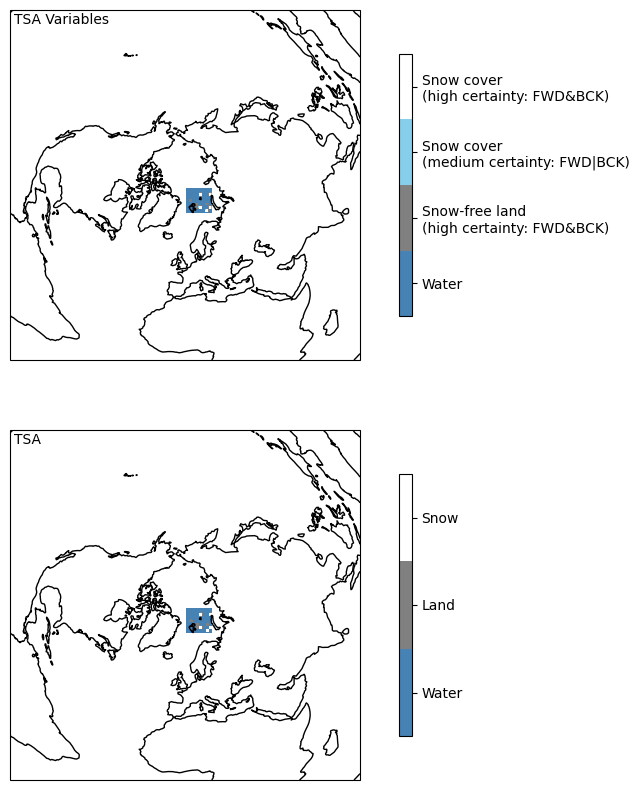

In [14]:
TSA_map = TSA_l2.copy()

TSA_map_flag = np.zeros(TSA_l2.shape)
TSA_map_flag[TSA_status_flag == 8] = np.nan
TSA_map_flag[TSA_status_flag == 0] = 0                              # water
TSA_map_flag[(TSA_status_flag == 1) & (TSA_uncertainty == 0)] = 1   # snow-free land (very likely)
TSA_map_flag[(TSA_status_flag == 2) & (TSA_uncertainty == 1)] = 2   # snow cover (likely)
TSA_map_flag[(TSA_status_flag == 2) & (TSA_uncertainty == 2)] = 3   # snow cover (very likely)

cart_crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10,10),
                       subplot_kw=dict(projection=cart_crs))

cmap = colors.ListedColormap(['steelblue', 'grey', 'skyblue', 'white'])
vrange=[-0.5,0.5,1.5,2.5,3.5]
norm = colors.BoundaryNorm(vrange, cmap.N)

img = ax[0].imshow(TSA_map_flag, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap)
ax[0].coastlines(color='black')
# ax[0].set_title('', fontsize='small')
ax[0].text(0.01,0.99,'TSA Variables',va='top',transform=ax[0].transAxes)
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[0,1,2,3], orientation='vertical', pad=0.05, shrink=0.75)
cbar.ax.set_yticklabels(['Water', 'Snow-free land\n(high certainty: FWD&BCK)', 'Snow cover\n(medium certainty: FWD|BCK)', 'Snow cover\n(high certainty: FWD&BCK)'])

cmap = colors.ListedColormap(['steelblue','grey', 'white'])
vrange=[-0.5,0.5,1.5,2.5]
norm = colors.BoundaryNorm(vrange, cmap.N)

img = ax[1].imshow(TSA_map, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap)
ax[1].coastlines(color='black')
# ax[1].set_title('', fontsize='small')
ax[1].text(0.01,0.99,'TSA',va='top',transform=ax[1].transAxes)
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[0,1,2], orientation='vertical', pad=0.05, shrink=0.75)
cbar.ax.set_yticklabels(['Water','Land','Snow'])

# fig.savefig('tsa_l2product.png', format='png', dpi=2400, bbox_inches='tight')

plt.show()

## Final TSA Product

Write to NetCDF File:

In [15]:
# get a template L2 format (netCDF/CF) from the Tools module
ds_l2 = l2.get_CIMR_L2_template('grid', geo_def=area_def, add_time=None)

# create DataArray for TSA from template
da_tsa = xr.DataArray(TSA_l2, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                        attrs=ds_l2['template'].attrs, name='tsa')
da_tsa.attrs['long_name'] = 'Terrestrial Snow Area ({} algorithm)'.format(algo)
da_tsa.attrs['standard_name'] = 'terrestrial_snow_area'
da_tsa.attrs['units'] = 1
da_tsa.attrs['coverage_content_type'] = 'NA'
da_tsa.attrs['auxiliary_variables'] = 'terrestrial_snow_area_uncertainty,status_flag'

# create DataArray for tsa_uncertainty from template
da_uncert = xr.DataArray(TSA_uncertainty, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                        attrs=ds_l2['template'].attrs, name='tsa_uncertainty')
da_uncert.attrs['long_name'] = 'Qualitative uncertainty for Terrestrial Snow Area'
da_uncert.attrs['standard_name'] = 'terrestrial_snow_area_uncertainty'
da_uncert.attrs['coverage_content_type'] = 'QualityInformation'
da_uncert.attrs['units'] = 1

# create DataArray for status_flag from template
da_flag = xr.DataArray(TSA_status_flag, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                        attrs=ds_l2['template'].attrs, name='status_flag')
da_flag.attrs['long_name'] = 'Status flag for Terrestrial Snow Area'
da_flag.attrs['coverage_content_type'] = 'AuxiliaryInformation'
da_flag.attrs['comment'] = status_flag_comment

In [16]:
# add data arrays to ds_l2 object
ds_l2 = ds_l2.merge(da_tsa)
ds_l2 = ds_l2.merge(da_uncert)
ds_l2 = ds_l2.merge(da_flag)

# customize global attributes
ds_l2.attrs['title'] = 'CIMR L2 NRT3H Terrestrial Snow Area'
ds_l2.attrs['summary'] = 'Terrestrial Snow Area computed with the prototype algorithm developed in the ESA CIMR DEVALGO study. The algorithm combines brightness temperatures from the Ku and Ka channels. The product file contains the TSA, its uncertainties, and status flag.'
ds_l2.attrs['l1b_file'] = l1b_path
ds_l2.attrs['algorithm_version'] = algo_version
ds_l2.attrs['creator_name'] = 'Lina Zschenderlein'
ds_l2.attrs['creator_email'] = 'lina.zschenderlein@fmi.fi'
ds_l2.attrs['institution'] = 'Finnish Meteorological Institute'

# remove 'template' variable
ds_l2 = ds_l2.drop('template')

# write to file
l2_n = 'cimr_devalgo_l2_tsa_{}_{}.nc'.format(l2_grid, test_card_name.replace('_','-'), )
l2_n = os.path.join(l2_dir, l2_n)
ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC')
print(l2_n)

C:/Users/zschende/OneDrive - Ilmatieteen laitos/Files/Projects/CIMR Devalgo/Data/L2 Files/cimr_devalgo_l2_tsa_ease2_nh_3.125km_devalgo-radiometric.nc
